# Elo Merchant Category Recommendation - Visualization
End date: _2019. february 19._<br/>

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In this section we will create visualizations of the input data to gain a comprehensive insight to the properties of the data.

In [1]:
import os
import gc
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

## Train and test data

In [2]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

201,917 records and 6 features in train set.
123,623 records and 5 features in test set.


In [3]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056


In [4]:
df_train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

The value of the target variable is ranging between -33.21 and 17.96. These number don't tell us much about the distribution of the variables, that's why we draw a histrogram of the values.

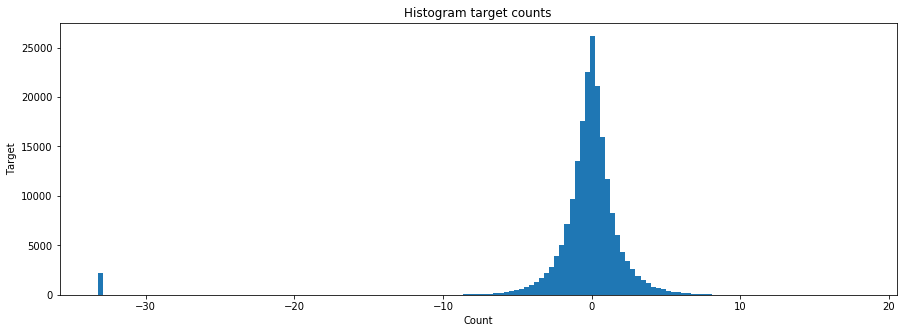

In [5]:
plt.figure(figsize=(15, 5))
plt.hist(df_train.target.values, bins=150)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

As you can see the majority of the values are between -8 and 8 and there is a spike of outliers around -33. Previously we have found out that the mean is -0.39, and the standard deviation is 3.85. Seems like if we chop off the outliers, the target values has normal distribution. Let's check it.

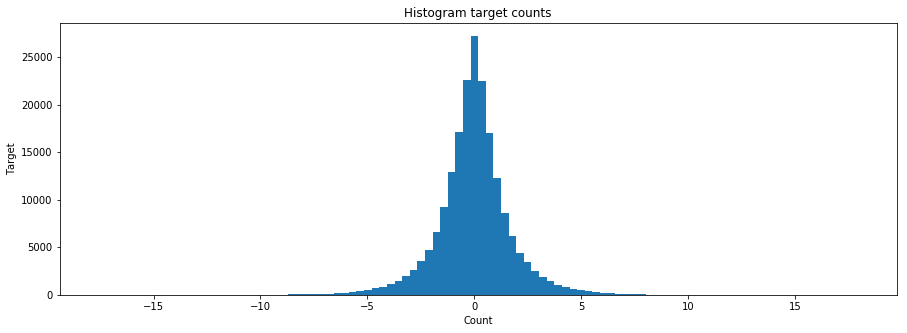

In [6]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -20].target.values, bins=100) # normal distribution
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

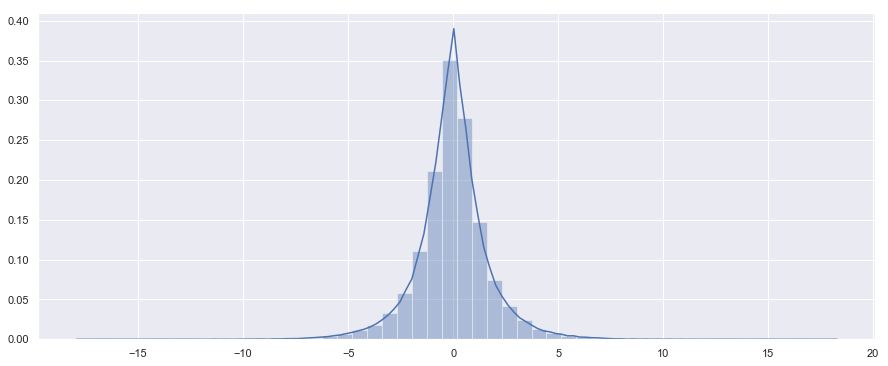

In [7]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.distplot(df_train[df_train['target'] > -20].target.values)

If we draw the line of the normal distribution to the chart, looks like it has a normal distribution, but let's go further with the checking of the statistics. The QQ plot shows the scatter plot of points in a diagonal line, closely fitting the expected diagonal pattern for a sample from a Gaussian distribution. As the plot below shows the deviations from the red line, it seems that the distribution of the target attribute is not normal.

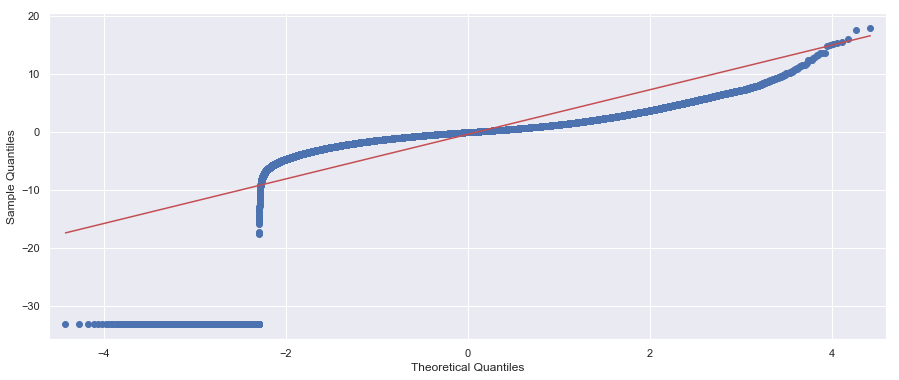

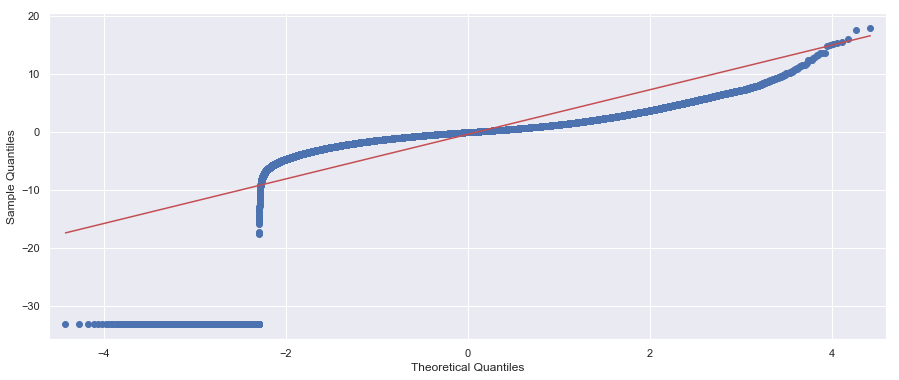

In [8]:
qqplot(df_train['target'], line='s')

In [9]:
print('Shapiro-Wilk Test normality test')
stat, p = stats.shapiro(df_train[df_train['target'] > -30].target.values)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.1
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk Test normality test
Statistics=0.949, p=0.000
Sample does not look Gaussian (reject H0)


As the p value is zero, the target attribute (without the outliers) is not drawn from normal distribution at any confidence level.

## Merchants and transactions

In [10]:
df_merch = pd.read_csv("input/merchants.csv")
df_nm_trans = pd.read_csv("input/new_merchant_transactions.csv")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))
print("{:,} records and {} features in new merchant transactions set.".format(df_nm_trans.shape[0], df_nm_trans.shape[1]))

334,696 records and 22 features in merchant set.
1,963,031 records and 14 features in new merchant transactions set.


In [11]:
df_merch[:3]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


In [12]:
df_nm_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14


First we'll get rid of the unnecessary category features

In [13]:
dropping = ['merchant_category_id', 'subsector_id', 'category_1', 'city_id', 'state_id', 'category_2']
for var in dropping:
    df_merch = df_merch.drop(var, axis = 1)

Join the data of the merchants and the transactions to the training set.

In [14]:
data = pd.merge(df_merch, df_nm_trans, on = 'merchant_id')
data = pd.merge(data, df_train, on = 'card_id')

Split the purchase date to date and time.

In [15]:
data['purchase_time'] = data['purchase_date'].str.split(' ')
data['purchase_date'] = data['purchase_time'].str[0]
data['purchase_time'] = data['purchase_time'].str[1]

Then extract the day of the week from the day of the date. The `pd.Categorical` function sets the order of the days of the week.

In [16]:
def get_weekday(date_string):
    date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return calendar.day_name[date.weekday()]

data['purchase_weekday'] = data['purchase_date'].apply(lambda x: get_weekday(x))

day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['purchase_weekday'] = pd.Categorical(data['purchase_weekday'], categories = day_labels, ordered = True)

In [17]:
data[:3]

,merchant_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,purchase_time,purchase_weekday
0,M_ID_c9eb20f6f5,25449,-0.057471,-0.057471,E,E,NaN,1.666667,3,NaN,...,1.0,16,18,2013-11,3,3,1,-0.242904,11:45:08,Wednesday
1,M_ID_063592fa97,62376,-0.057471,-0.057471,E,E,2.38,2.284722,3,2.31,...,1.0,16,21,2013-11,3,3,1,-0.242904,15:40:28,Monday
2,M_ID_7f86c618d3,99247,-0.057471,-0.057471,D,C,0.98,0.953118,3,0.91,...,1.0,16,37,2013-11,3,3,1,-0.242904,20:43:36,Friday


The default behavior in Seaborn is to aggregate the multiple measurements at each x value by plotting the mean and the 95% confidence interval around the mean. (More info on [Aggregation and representing uncertainty](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty))

Text(0.5,0,'Purchase Weekday')

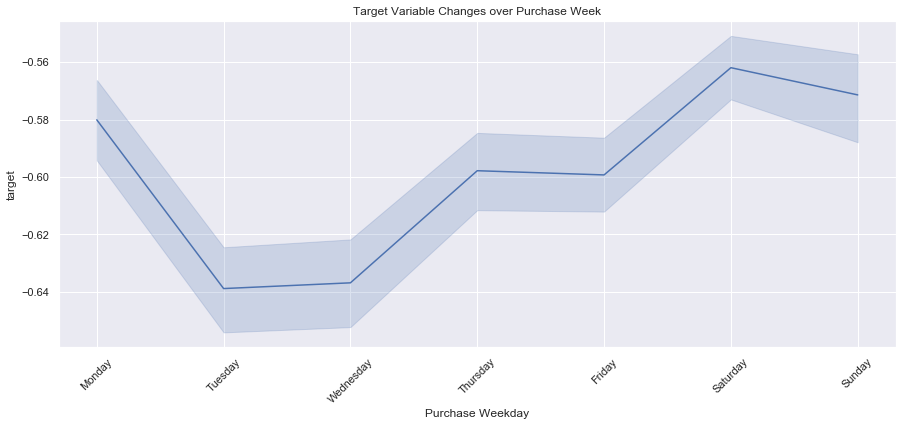

In [18]:
ax = sns.lineplot(x = "purchase_weekday", y = "target", markers = False, dashes = True, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Week')
ax.set_xlabel('Purchase Weekday')

The plot above shows the target changes over the week.

In [19]:
def get_month(date_string, kind = 'month'):
    if kind == 'month':
        date = datetime.datetime.strptime(date_string, '%Y-%m')
    elif kind == 'day':
        date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return date.strftime("%B")

data['purchase_month'] = data['purchase_date'].apply(lambda x: get_month(x, kind='day'))
data['first_active_month2'] = data['first_active_month'].apply(lambda x: get_month(x))

month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['purchase_month'] = pd.Categorical(data['purchase_month'], categories = month_labels, ordered = True)
data['first_active_month2'] = pd.Categorical(data['first_active_month2'], categories = month_labels, ordered = True)

Text(0.5,0,'Purchase Month')

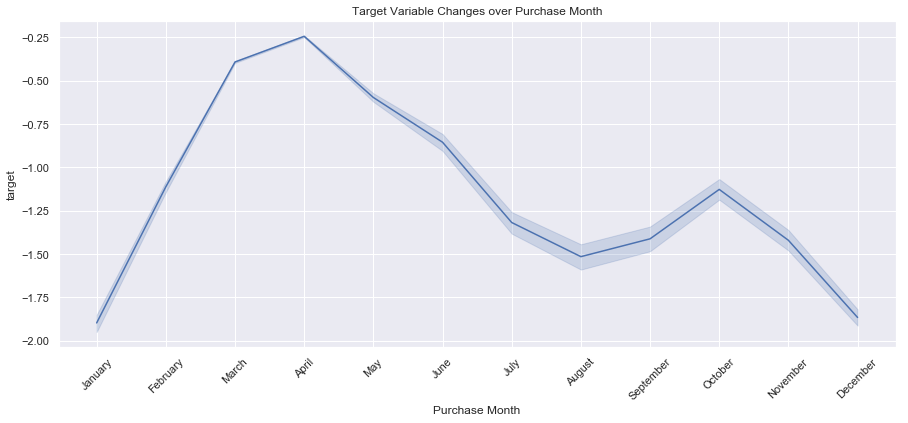

In [20]:
ax = sns.lineplot(x = "purchase_month", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Month')
ax.set_xlabel('Purchase Month')

The plot shows the target changes over the month.

In [21]:
data['first_active_year'] = data['first_active_month'].str[:4]

year_labels = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
data['first_active_year'] = pd.Categorical(data['first_active_year'], categories = year_labels, ordered = True)

Text(0.5,0,'First Active Year')

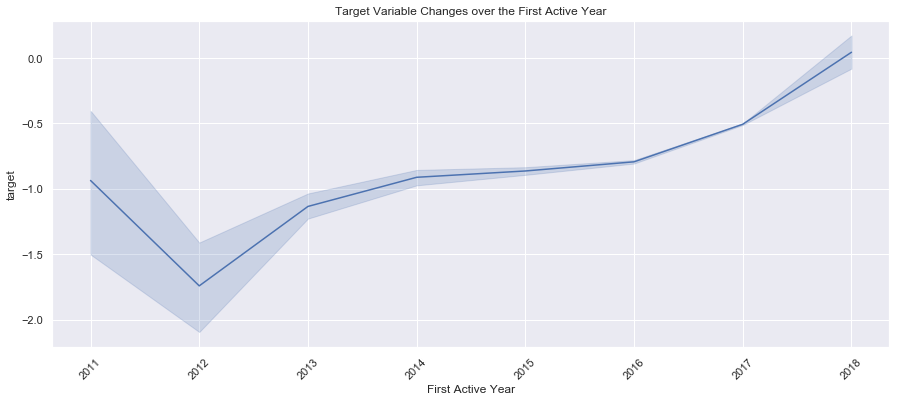

In [22]:
ax = sns.lineplot(x = "first_active_year", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Year')
ax.set_xlabel('First Active Year')

The plot shows the target changes over the first active year.

Text(0.5,0,'First Active Month')

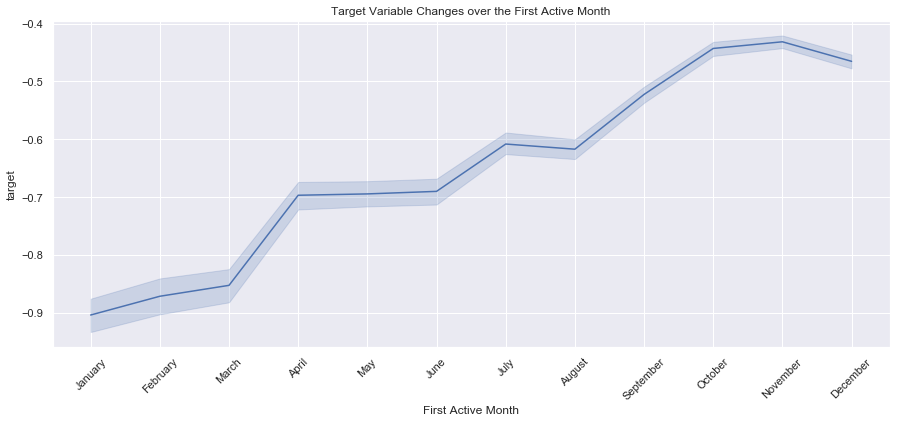

In [23]:
ax = sns.lineplot(x = "first_active_month2", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Month')
ax.set_xlabel('First Active Month')

The plot showst the target changes over the first active month.

In [24]:
data['temp'] = data['purchase_time'].str.split(':')

def get_session(time_list):
    time_list[0] = int(time_list[0])
    if time_list[0] > 4 and time_list[0] < 12:
        return 'Morning'
    elif time_list[0] >= 12 and time_list[0] < 17:
        return 'Afternoon'
    elif time_list[0] >= 17 and time_list[0] < 21:
        return 'Evening'
    else:
        return 'Night'
    
data['purchase_session'] = data['temp'].apply(lambda x: get_session(x))

session_labels = ['Morning', 'Afternoon', 'Evening', 'Night']
data['purchase_session'] = pd.Categorical(data['purchase_session'], categories = session_labels, ordered = True)
data.drop('temp', axis = 1, inplace=True)

Text(0.5,0,'Purchase Time of Day')

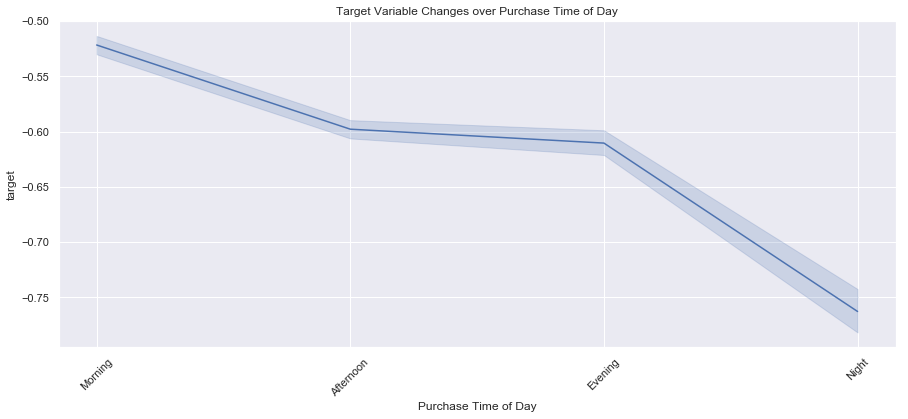

In [25]:
ax = sns.lineplot(x = "purchase_session", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Time of Day')
ax.set_xlabel('Purchase Time of Day')

The plot shows the target changes over the purchase time of day.

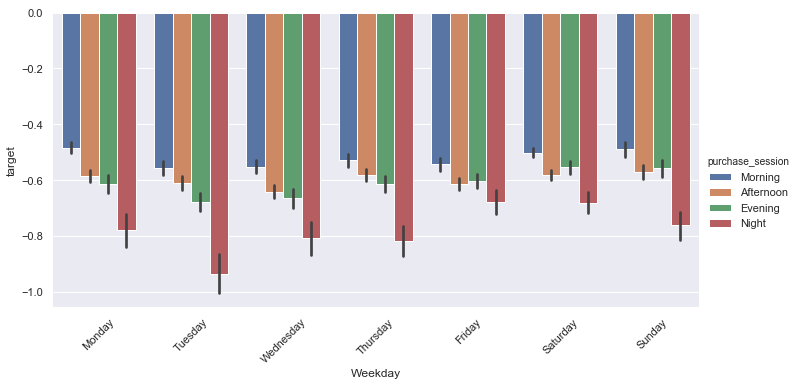

In [26]:
ax = sns.catplot(x='purchase_weekday', y='target', hue='purchase_session', data=data, kind='bar', height=5, aspect=2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("target")
ax.set_xlabels('Weekday')

In [27]:
def get_time_of_month_cat(date):
    date_temp = date.split('-')
    if int(date_temp[2]) < 10:
        time_of_month = 'Beginning'
    elif int(date_temp[2]) >= 10 and int(date_temp[2]) < 20:
        time_of_month = 'Middle'
    else:
        time_of_month = 'End'
    return time_of_month

data['time_of_month_cat'] = data['purchase_date'].apply(lambda x: get_time_of_month_cat(x))

tof_labels = ['Beginning', 'Middle', 'End']
data['time_of_month_cat'] = pd.Categorical(data['time_of_month_cat'], categories=tof_labels, ordered=True)

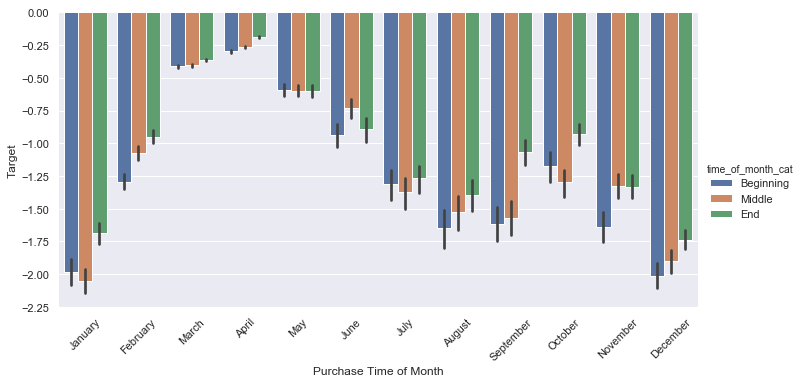

In [28]:
ax = sns.catplot(x='purchase_month', y='target', hue='time_of_month_cat', data=data, kind='bar', height=5, aspect=2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("Target")
ax.set_xlabels('Purchase Time of Month')

The plot shows the target changes over the purchase time of month.

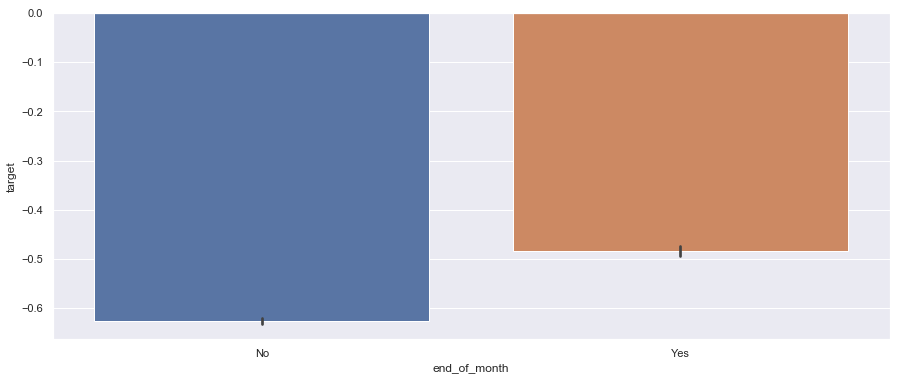

In [29]:
def get_end_of_month(date):
    date_temp = date.split('-')
    if int(date_temp[2]) >= 25:
        end_of_month = 'Yes'
    else:
        end_of_month = 'No'
    return end_of_month

data['end_of_month'] = data['purchase_date'].apply(lambda x: get_end_of_month(x))

ax = sns.barplot(x = 'end_of_month', y = 'target', data = data)